In [1]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from ipynb.fs.full.dataset import spam_test_train_set
from ipynb.fs.full.dataset import confusion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

/home/titli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BASE_DIR = ''
#GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')



Indexing word vectors.


In [3]:
embeddings_index = {}
with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')



Found 400000 word vectors.
Processing text dataset


In [4]:
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))



Found 19997 texts.


In [5]:
entire = pd.DataFrame({'text': texts, 'labels': labels})
entire.to_csv('entire.csv')
## Loading data
keras_data = pd.read_csv('entire.csv', index_col=0)
keras_data.tail()

,labels,text
19992,19,\n\nIn article <930426.140835.4f1.rusnews.w165...
19993,19,\n\nIn article <1993Apr27.073723.18577@csis.di...
19994,19,\n\nIn article <1rc1f3INN7rl@emx.cc.utexas.edu...
19995,19,\n\n\nIn article <1993Apr26.231845.13843@digi....
19996,19,\n\nIn article <C64H4w.BFH@darkside.osrhe.uokn...


In [6]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(keras_data.text)
sequences = tokenizer.texts_to_sequences(keras_data.text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')



Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Training model.


In [7]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/10
15998/15998 [==============================] - 416s 26ms/step - loss: 2.4478 - acc: 0.1945 - val_loss: 1.9116 - val_acc: 0.3338
Epoch 2/10
15998/15998 [==============================] - 436s 27ms/step - loss: 1.6107 - acc: 0.4396 - val_loss: 1.3741 - val_acc: 0.5194
Epoch 3/10
15998/15998 [==============================] - 415s 26ms/step - loss: 1.2185 - acc: 0.5822 - val_loss: 1.1262 - val_acc: 0.6174
Epoch 4/10
15998/15998 [==============================] - 440s 28ms/step - loss: 1.0031 - acc: 0.6581 - val_loss: 1.0597 - val_acc: 0.6332
Epoch 5/10
15998/15998 [==============================] - 434s 27ms/step - loss: 0.8576 - acc: 0.7065 - val_loss: 0.9190 - val_acc: 0.6874
Epoch 6/10
15998/15998 [==============================] - 388s 24ms/step - loss: 0.7451 - acc: 0.7475 - val_loss: 1.0086 - val_acc: 0.6574
Epoch 7/10
15998/15998 [==============================] - 384s 24ms/step - loss: 0.6423 - acc: 0.7783 - val_loss: 0.9

In [8]:
model_json = model.to_json()
with open("modelkera.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelkera.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    sns.set(rc={"figure.figsize": (8, 6)})
    sns.set_style("white")
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label = 'Training loss')
                 
        #label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label = 'Validation loss')
        #label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    plt.tick_params(direction='out', length=6, width=2, colors='k')
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    #plt.title('Loss ',fontsize=20)
    plt.xlabel('Epochs',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.legend()
    plt.savefig('1000_1.png', bbox_inches='tight')
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label = 'Training accuracy')
        #label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label = 'Validation accuracy')
        #label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.tick_params(direction='out', length=6, width=2, colors='k')
    plt.tick_params(axis='both', which='major', labelsize=16)
    #plt.title('Accuracy ',fontsize=20)
    plt.xlabel('Epochs',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.legend()
    plt.savefig('1000_2.png', bbox_inches='tight')
    plt.show()

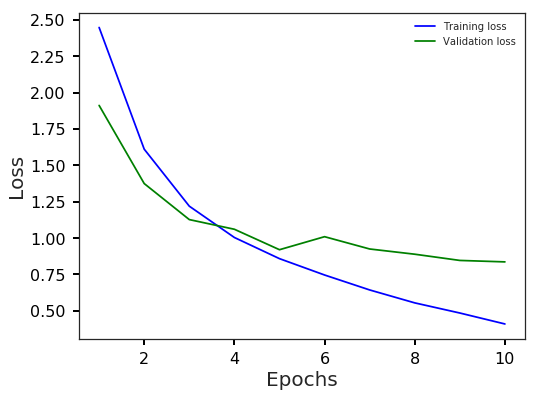

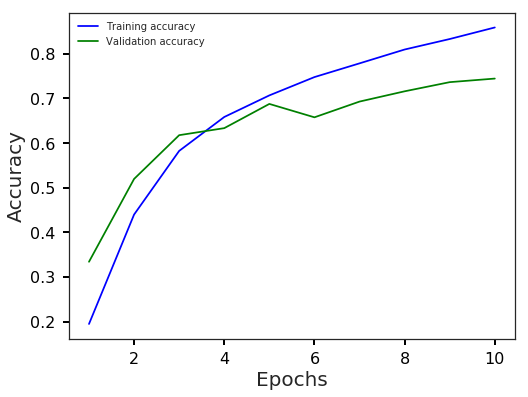

In [10]:
plot_history(history)